# One-Stop Notebook for CSRNet Dataset Preparation

For Model Training workflow, this is Step 1.

## 0.0 RGBhr to RGB renaming

some files end with RGBhr and some end with RGB. Its a pain, and i still have some rules to account for it in other notebooks. But here, we remove it entirely.

In [1]:
import os

In [2]:
input_images_folder = r'base_images_folder'

for file_name in os.listdir(input_images_folder):
    # Check if the file ends with 'RGBhr.png', some of our files did and it caused untold amounts of error
    if file_name.endswith('RGBhr.png'):
        
        old_file_path = os.path.join(input_images_folder, file_name)
        new_file_name = file_name.replace('RGBhr.png', 'RGB.png') # Losing the hr fixes it
        new_file_path = os.path.join(input_images_folder, new_file_name)
        
        # Rename the file
        os.rename(old_file_path, new_file_path)
        print(f"Renamed: {file_name} to {new_file_name}")

print("Renaming complete for images ending in 'RGBhr.png'.")

Renaming complete for images ending in 'RGBhr.png'.


## 1.0 Image checking and Resize

### Image Dimension Grouping and Tracker

In [3]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

In [4]:
input_images_folder = r'where_are_your_images'
input_annotations_folder = r'where_are_your_annotations'
output_images_folder = r'resized_images' # For implementation, I set everything to train image folder, then ran a dataset splitter from there
output_annotations_folder = r'adjusted_annotations'

In [5]:
# Check the output directories exist
os.makedirs(output_images_folder, exist_ok=True)
os.makedirs(output_annotations_folder, exist_ok=True)

In [6]:
# This checks the file dimensions of all images in the input folder and returns the count of each dimension 'group', part of the sanity check
image_sizes = []
count = {}
for root, dirs, files in os.walk(input_images_folder):
   for file in files:
       img = Image.open(os.path.join(root, file))
       width, height = img.size
       image_sizes.append((width,height))
       
       if (width, height) not in count: # If count does not have the key width, height then make it
           count[(width, height)] = 0
           
       count[(width, height)] += 1 # add plus one to the count of that width, height
   
for k, v in sorted(count.items()):
   print('%sx%s: %d' % (k[::-1] + (v,))) # k being the keys, printed in reverse, v is the count

202x308: 1120
373x548: 967


### 1.1 Prep for CSRNet
This resizes the images, and scales the annotations at the same time.

In [7]:
def preprocess_image_and_annotations(image_path, annotation_path, output_image_path, output_annotation_path, target_size=(224, 224)):

    image = Image.open(image_path)
    original_width, original_height = image.size
    
    image.thumbnail(target_size, Image.Resampling.LANCZOS) # thumbnail used to maintain aspect ratio, LANCZOS sample used
    resized_width, resized_height = image.size # this now stores the new width and height
    
    # This gets us the difference between sizes to make padding with
    w = target_size[0] - resized_width
    h = target_size[1] - resized_height
    padding = (w // 2, h // 2, w - (w // 2), h - (h // 2)) # padding: left, top, right, bottom. Floor division used to discard
    image = ImageOps.expand(image, padding)
    
    image.save(output_image_path) # saves new image
    
    # And this scales the annotations to match
    annotations = pd.read_csv(annotation_path)
    if 'c-x' in annotations.columns and 'c-y' in annotations.columns:

        annotations['c-x'] = annotations['c-x'] * (resized_width / original_width) + padding[0]
        annotations['c-y'] = annotations['c-y'] * (resized_height / original_height) + padding[1]
    
    annotations.to_csv(output_annotation_path, index=False)
    print(f"Processed and saved image to {output_image_path} and annotations to {output_annotation_path}")

In [8]:
# This runs the function
for file_name in os.listdir(input_images_folder):
    if file_name.endswith('.png'):
        input_image_path = os.path.join(input_images_folder, file_name)
        output_image_path = os.path.join(output_images_folder, file_name)
        
        annotation_file_name = file_name.replace('.png', '.csv')
        input_annotation_path = os.path.join(input_annotations_folder, annotation_file_name)
        output_annotation_path = os.path.join(output_annotations_folder, annotation_file_name)
        
        if os.path.exists(input_annotation_path):
            preprocess_image_and_annotations(input_image_path, input_annotation_path, output_image_path, output_annotation_path)

Processed and saved image to D:\AI\CSRNet\dataset\train\images\20130320T004348.182606.Cam6_54.png and annotations to D:\AI\CSRNet\dataset\train\annotations\20130320T004348.182606.Cam6_54.csv
Processed and saved image to D:\AI\CSRNet\dataset\train\images\20130320T004348.754118.Cam6_13.png and annotations to D:\AI\CSRNet\dataset\train\annotations\20130320T004348.754118.Cam6_13.csv
Processed and saved image to D:\AI\CSRNet\dataset\train\images\20130320T004349.135000.Cam6_11.png and annotations to D:\AI\CSRNet\dataset\train\annotations\20130320T004349.135000.Cam6_11.csv
Processed and saved image to D:\AI\CSRNet\dataset\train\images\20130320T004349.516008.Cam6_43.png and annotations to D:\AI\CSRNet\dataset\train\annotations\20130320T004349.516008.Cam6_43.csv
Processed and saved image to D:\AI\CSRNet\dataset\train\images\20130320T004351.039789.Cam6_32.png and annotations to D:\AI\CSRNet\dataset\train\annotations\20130320T004351.039789.Cam6_32.csv
Processed and saved image to D:\AI\CSRNet\dat

### 1.2 Sanity check for output files

In [9]:
# This checks the file dimensions of all images in the output folder, scaled
image_sizes = []
count = {}
for root, dirs, files in os.walk(output_images_folder):
   for file in files:
       img = Image.open(os.path.join(root, file))
       width, height = img.size
       image_sizes.append((width,height))
       
       if (width, height) not in count:
           count[(width, height)] = 0
           
       count[(width, height)] += 1
   
for k, v in sorted(count.items()):
   print('%sx%s: %d' % (k[::-1] + (v,))) # Ideally, there will be only 1 group: 224 x 224

224x224: 2087


In [10]:
# Sanity check: Randomly select an image and display it with annotations plotted
def validate_random_image():
    processed_images = [f for f in os.listdir(output_images_folder) if f.endswith('.png')]
    if not processed_images:
        print("No images found for validation.")
        return

    # Choose a random image
    random_image_name = random.choice(processed_images)
    random_image_path = os.path.join(output_images_folder, random_image_name)
    random_annotation_path = os.path.join(output_annotations_folder, random_image_name.replace('.png', '.csv'))
    
    # Load the image and annotations
    image = Image.open(random_image_path)
    annotations = pd.read_csv(random_annotation_path)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.scatter(annotations['c-x'], annotations['c-y'], color='red', s=10, marker='o')
    plt.title(f"Validation: {random_image_name}")
    plt.show()

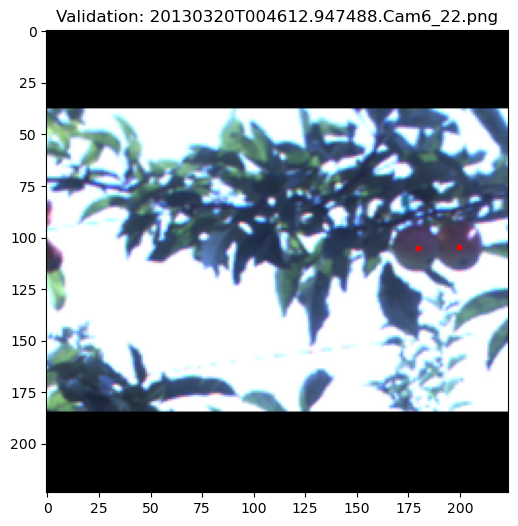

In [11]:
validate_random_image()

## 2.0 Annotation Checking for Resized Images

This is now handled in the same function as the image scaling.

## 3.0 80:20 split on adjusted files and annotations

In [12]:
import os
import shutil
import random

In [13]:
train_images_folder = r'new_train_images' # Above function put images here
test_images_folder = r'new_test_images' # Empty folder for now
train_annotations_folder = r'new_train_annotations' # Above function put annotations here here
test_annotations_folder = r'new_test_annotations' # Empty folder for now

In [14]:
os.makedirs(test_images_folder, exist_ok=True)
os.makedirs(test_annotations_folder, exist_ok=True)

In [15]:
image_files = [f for f in os.listdir(train_images_folder) if f.endswith('.png')]

# Determine 20% of the images at random
test_size = int(0.2 * len(image_files))
test_images = random.sample(image_files, test_size)

In [16]:
# Move selected images and their corresponding annotations
for image_file in test_images:
    # Define full paths for images
    source_image_path = os.path.join(train_images_folder, image_file) # For me this was train
    destination_image_path = os.path.join(test_images_folder, image_file) # This was test
    
    # Define corresponding annotation file name and paths
    annotation_file = image_file.replace('.png', '.csv')
    source_annotation_path = os.path.join(train_annotations_folder, annotation_file)
    destination_annotation_path = os.path.join(test_annotations_folder, annotation_file)
    
    # Check if both image and annotation exist, move only if both are present
    if os.path.exists(source_image_path) and os.path.exists(source_annotation_path):
        shutil.move(source_image_path, destination_image_path)
        shutil.move(source_annotation_path, destination_annotation_path)
    else:
        print(f"Warning: Skipping {image_file} as its corresponding annotation file is missing.")

print("Dataset split complete. Images and annotations have been moved to the test folder.")

Dataset split complete. Images and annotations have been moved to the test folder.


### Did that work?

In [17]:
def check_corresponding_files(images_folder, annotations_folder):
    # Get list of images and annotations
    image_files = [f for f in os.listdir(images_folder) if f.endswith('.png')]
    annotation_files = [f for f in os.listdir(annotations_folder) if f.endswith('.csv')]

    image_basenames = {os.path.splitext(f)[0] for f in image_files}
    annotation_basenames = {os.path.splitext(f)[0] for f in annotation_files}

    # Any mismatches?
    missing_annotations = image_basenames - annotation_basenames
    extra_annotations = annotation_basenames - image_basenames

    # Report results with counts
    print(f"\nChecking folder: {images_folder}")
    if missing_annotations:
        print(f"Missing annotations for {len(missing_annotations)} images: {missing_annotations}")
    else:
        print("All images have corresponding annotations.")
    
    if extra_annotations:
        print(f"Extra annotations without images for {len(extra_annotations)} annotations: {extra_annotations}")
    else:
        print("No extra annotations without corresponding images.")
    
    return len(missing_annotations), len(extra_annotations)

In [18]:
# Check train and test folders
print("Checking training folder consistency:")
train_missing, train_extra = check_corresponding_files(train_images_folder, train_annotations_folder)

print("\nChecking testing folder consistency:")
test_missing, test_extra = check_corresponding_files(test_images_folder, test_annotations_folder)

Checking training folder consistency:

Checking folder: D:\AI\CSRNet\dataset\train\images
All images have corresponding annotations.
No extra annotations without corresponding images.

Checking testing folder consistency:

Checking folder: D:\AI\CSRNet\dataset\test\images
All images have corresponding annotations.
No extra annotations without corresponding images.


In [19]:
# Summary
print("\nSummary:")
print(f"Train folder - Missing annotations: {train_missing}, Extra annotations: {train_extra}")
print(f"Test folder - Missing annotations: {test_missing}, Extra annotations: {test_extra}")


Summary:
Train folder - Missing annotations: 0, Extra annotations: 0
Test folder - Missing annotations: 0, Extra annotations: 0


Now go to ```CSV_to_H5.ipynb```